In [15]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import seaborn as sns
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neural_network import MLPRegressor
from os import walk
import matplotlib.pyplot as plt

In [2]:
# Data Organization

filenames = next(walk("c:\\Users\\coope\\Jupyter\\QCLI"))[2]
baselines = []
bites = []
blinks = []

for i in filenames:
    if i[-1] == 'v':
        data = pd.read_csv(i)
        data.drop(columns = ['channel1','channel2','channel3','channel4','Unnamed: 0'],inplace= True)
        init = data['time'][0]
        for j in range(len(data['time'])):
            data['time'][j] = data['time'][j] - init
            
    if i[-6:-4] == 'ne':
        baselines.append(data)
    if i[-6:-4] == 'te':
        bites.append(data)
    if i[-6:-4] == 'nk':
        blinks.append(data)

channels = ['c1','c2','c3','c4']

In [21]:
# DataEngineering takes in a single recording and visualizes/organizes the data

class DataEngineering:
    
    def __init__(self,data,channels,action,rolling = 80,len_slice = 300,overlap = 0.5):
        self.data = data
        self.channels = channels
        self.action = action
        self.rolling = rolling
        self.len_slice = len_slice
        self.overlap = overlap
        
    #   Visualization Functions 

    def plot_time(self):
        plt.figure(figsize=(16, 6))
        plt.plot(self.data)
        plt.xlabel('Time[s]')
        plt.ylabel('Amplitude')
        plt.legend(channels)
        plt.show()
    
    def plot_frequency(self):
        plt.figure(figsize=(16, 6))
        for i in channels:
            Y = np.fft.fft(self.data[i])
            plt.plot(np.abs(Y),label = i)
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
    
    def create_pairplot(self):
        sns.pairplot(self.data, diag_kind = 'kde')
    
    # Data Analysis and Feature Extraction
    
    def rolling_mean_sensor(self,channel_num,zero_centered = False):
        Data = self.data[channels[channel_num]]
        
        a = np.arange(len(Data))
        mean = np.zeros(len(Data))
        
        k_actual = self.rolling
        k = int(k_actual/2)
        mean[a<=k] = (1/(k*2))
        mean[-k:] =  (1/(k*2))
        meanhat = np.fft.fft(mean)
        datahat = np.fft.fft(Data)
        fhat = meanhat*datahat
        f = np.abs(np.fft.ifft(fhat))
        
        if zero_centered:
            f = f - np.median(f)
        return f
    
    def create_signal_slices(self,channel_num,zero_centered=False):
        X = []
        X_indecies = []
        if zero_centered:
            Data = np.array(self.rolling_mean_sensor(channel_num,zero_centered = True))
        else:
            Data = np.array(self.rolling_mean_sensor(channel_num))
        Data_indecies = np.arange(len(Data))
        i = 0
        backtrack = self.overlap*self.len_slice
        while (i+self.len_slice)<len(Data):
            start = i
            end = i + self.len_slice
            xi = Data[start:end]
            X.append(xi)
            X_indecies.append(Data_indecies[start:end])
            i = int(end - backtrack)
        return(X,X_indecies)
    
    def event_function(self,start,end):
        y = np.zeros(len(self.data))
        y[start:end] = 1
        y_indecies = np.arange(start,end)
        return(y,y_indecies)
    
    def create_y(self,start,end): #Labeling the slices that contain the event as 1
        a,y_indecies = self.event_function(start,end)
        x,idx = self.create_signal_slices(0)

        num_slices = len(idx)
        y = np.zeros(num_slices)
        for j in range(num_slices):
            for k in range(self.len_slice):
                if sum(np.isin(y_indecies,idx[j][k])) == 1:
                    y[j] = 1
                    break
        return y
    
    def create_X(self): #Concatenating the slices of each sensor
        df = pd.DataFrame()
        for i in range(len(self.channels)):
            xi,xi_ind = self.create_signal_slices(i,zero_centered = True)
            df_i = pd.DataFrame(xi).transpose()
            df = pd.concat([df,df_i])
        
        df.index = np.linspace(0,len(df)-1,len(df))
        
        X = []
        for i in range(np.shape(df)[1]):
            X.append(list(df[i]))
        
        return(df,X)

In [4]:
# EventDetectionAI will train and deploy the deep learning model for detecting events

class EventDetectionAI:
    
    def __init__(self,channels,action1,a1_start,a1_end,action2,a2_start,a2_end,baselines,names):
        self.channels = channels
        self.action1 = action1
        self.action2 = action2
        self.a1_start = a1_start
        self.a1_end = a1_end
        self.a2_start = a2_start
        self.a2_end = a2_end
        self.baselines = baselines
        self.names = names
    
    def organize_data(self):
        X_total = []
        y_total = []
        actions_data = [self.action1,self.action2,self.baselines]
        
        for i in range(len(actions_data)):
            for j in range(len(actions_data[i])):
                t = DataEngineering(actions_data[i][j],channels,'action')
                
                if self.names[i] == self.names[0]: 
                    yi = list(t.create_y(self.a1_start[j],self.a1_end[j]))
                    df,xi = t.create_X()
                    
                elif self.names[i] == self.names[1]:
                    yi = list(t.create_y(self.a2_start[j],self.a2_end[j]))
                    df,xi = t.create_X()           
                
                elif self.names[i] == 'baselines':
                    yi = list(t.create_y(0,0))
                    df,xi = t.create_X()
                    
                y_total += yi
                X_total += xi
                
        return X_total,y_total
    
    def event_model(self,X_total,y_total):
        model = Sequential([
            keras.Input(shape=(1200,)),
            Dense(1000, activation='tanh'),
            Dense(300, activation='tanh'),
            Dense(30, activation='tanh'),
            Dense(1,activation = 'sigmoid')
        ])
        
        model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['accuracy','mse'])
        
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_total, y_total, test_size = 0.02)
        model.fit(X_train,y_train,epochs = 20)
        
        return model
    
    def detect_events(self,model,action,run_num): 
        data_class = DataEngineering(action[run_num],self.channels,'action')
        df,data = data_class.create_X()
        
        predicted = model.predict(data)
        scaled_y = np.zeros(len(data_class.data))
        slices = np.shape(data)[0]
        
        indecies = []
        backtrack = data_class.overlap*data_class.len_slice
        i=0
        while (i+data_class.len_slice)<len(data_class.data):
            start = i
            end = i + data_class.len_slice
            ind_i = [start,end]
            indecies.append(ind_i)
            i = int(end - backtrack)
        
        for i in range(len(predicted)):
            scaled_y[indecies[i][0]:indecies[i][1]] = predicted[i]
        
        return scaled_y
    
    def plot_detection(self,model,action,run_num):
        data_class = DataEngineering(action[run_num],self.channels,'action')
        sy = self.detect_events(model,action,run_num)

        plt.figure(figsize=(16, 6))
        for i in range(len(self.channels)):
            plt.plot(data_class.rolling_mean_sensor(i,zero_centered=True))
        plt.title('Recorded Data')
        plt.xlabel('Time[s]')
        plt.ylabel('Rolling Mean Amplitude')
        plt.show()

        plt.figure(figsize=(16, 6))
        plt.plot(sy)
        plt.title('Event Detection AI Prediction')
        plt.xlabel('Time[s]')
        plt.ylabel('Certainty of Event [%]')
        plt.show()

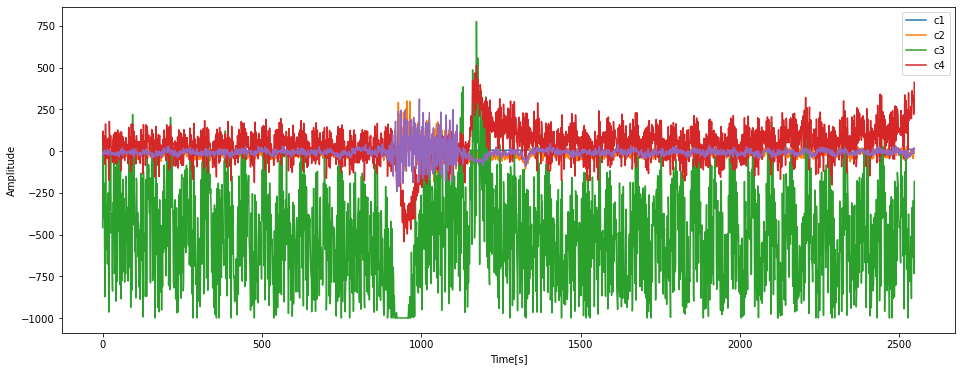

In [16]:
test = DataEngineering(bites[1],channels,'action')
test.plot_time()

In [22]:
bites_start = [490,850,300,300,400,800]
bites_end = [1000,1300,900,550,900,1100]
blinks_start = [700,600,500,800,800,900]
blinks_end = [1200,850,1000,1100,1100,1200]
names = ['bites','blinks','baselines']

AI = EventDetectionAI(channels,bites,bites_start,bites_end,blinks,blinks_start,blinks_end,baselines,names)
X_total,y_total = AI.organize_data()

In [23]:
modelo = AI.event_model(X_total,y_total)

Epoch 1/20


ValueError: in user code:

    File "C:\Users\coope\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\coope\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\coope\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\coope\anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\coope\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\coope\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 1200), found shape=(None, 600)


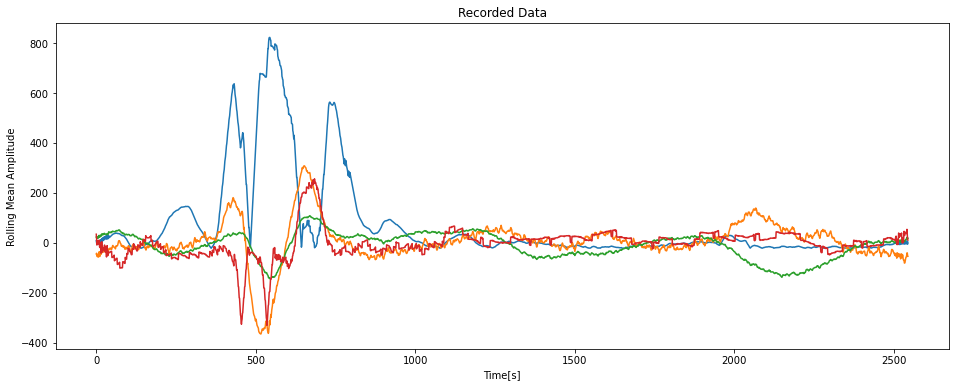

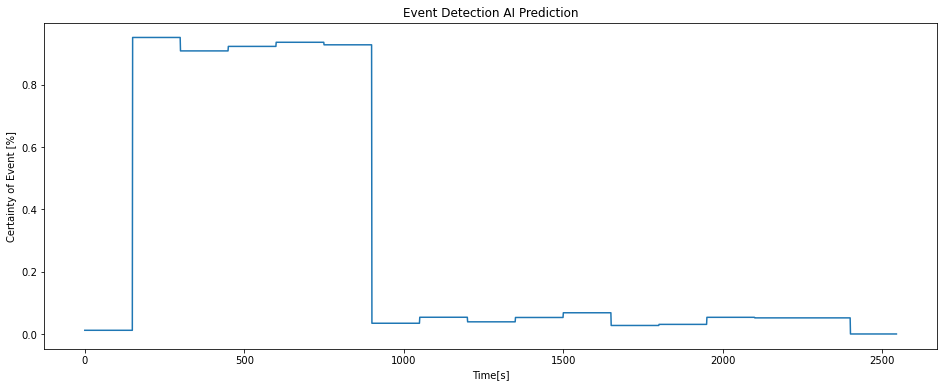

In [20]:
action = bites
run_num = 2
AI.plot_detection(modelo,action,run_num)

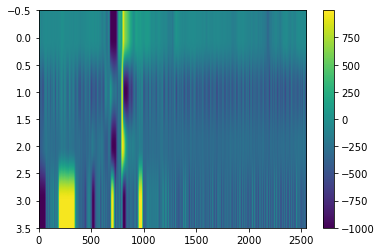

In [8]:
# Plotting the data of all of the channels as an image 
a1 = blinks[2]
b1 = np.zeros([4,len(a1)])
for i in range(4):
    b1[i,:] = a1[channels[i]]
plt.imshow(b1,aspect = 'auto',norm=plt.Normalize())
plt.colorbar()
#plt.xlim(250,750)

In [9]:
def create_image_slices(sensor_data,num_slices):
    X = []
    slice_len = int(len(sensor_data)/num_slices)
    indecies = slice_len*np.arange(num_slices)
    for i in range(1,len(indecies)):
        xi = np.zeros([2000,slice_len])
        sliced = np.array(sensor_data[indecies[i-1]:indecies[i]])
        for j in range(len(sliced)):
            if sliced[j]<0: 
                xi[int(np.abs(sliced[j])),j] = 1
            else:
                xi[int(sliced[j])+1000,j] = 1
        X.append(xi)
    return(X)

In [10]:
def rolling_mean_sensor(action,run_num,channels,sensor,rolling):
    data = action[run_num][channels[sensor]]
    a = np.arange(len(data))
    mean = np.zeros(len(data))
    
    k_actual = rolling
    k = int(k_actual/2)
    mean[a<=k] = (1/(k*2))
    mean[-k:] =  (1/(k*2))
    meanhat = np.fft.fft(mean)
    datahat = np.fft.fft(data)
    fhat = meanhat*datahat
    f = np.fft.ifft(fhat)
    return np.abs(f)

In [11]:
def heaviside(start,end,length):
    y = np.zeros(length)
    y[start:end] = 1
    return y

In [12]:
#Plotting time series data of an action
def plot_all_runs(action,channels):
    for record in action:
        plt.figure(figsize=(16, 2))
        for j in channels:
            t = record['time']
            y = record[j]
            plt.plot(t,y)
        plt.show()

In [13]:
def create_signal_slices(sensor_data,len_slice,overlap):
    X = []
    data = np.array(sensor_data)
    i = 0
    backtrack = overlap*len_slice
    while (i+len_slice)<len(data):
        start = i
        end = i + len_slice
        xi = data[start:end]
        X.append(xi)
        i = int(end - backtrack)
    return(X)